# Calculate the confidence of the jets found in the subjects
## Need the aggregator files (in the reductions/ folder)
In this jupyter notebook we take a look at the confidence of the detected jets. The confidence is calculated as a number between 0-1 with 1 being the highest score.
Looking at these results we can see the quality of the jets we detected, and a cut could possible be made to isolate the poorer performing jets. 


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from aggregation import Aggregator, create_gif
from astropy.io import ascii
from astropy.table import Table
import numpy as np
plt.style.use('default')
from skimage import io
import ast
import tqdm

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


In [2]:
aggregator = Aggregator('reductions/point_reducer_hdbscan_box_the_jets.csv',
                        'reductions/shape_reducer_dbscan_box_the_jets.csv')

Get a list of subjects from the CSV file

In [3]:
subs = aggregator.get_subjects()

We will now calculate the confidence value of each jet in the subjects and add it to the `confs` variable

In [4]:
sub_ids = []
confs = []

for sub in tqdm.tqdm(subs):
    box_data = aggregator.box_data[:][(aggregator.box_data['subject_id'] == sub) & (
        aggregator.box_data['task'] == 'T1')]
    try:
        sigma = np.asarray(ast.literal_eval(box_data[f'data.frame0.T1_tool2_clusters_sigma'][0]))
#         aggregator.plot_subject(sub, 'T1')
        confs.extend(sigma)
        sub_ids.extend([sub]*len(sigma))
    except Exception as e:
        #         print(e)
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:19<00:00, 165.94it/s]


`confs` is the uncertainty in the box. We can convert this to $\gamma$ by doing $\gamma = \sqrt{1 - \sigma}$

In [5]:
confs = np.asarray(confs)
sub_ids = np.asarray(sub_ids)
gamma = np.sqrt(1. - confs)
print(confs.min(), confs.max())
gamma[np.isnan(gamma)] = 0.

0.056744243179246305 0.6788737299247579


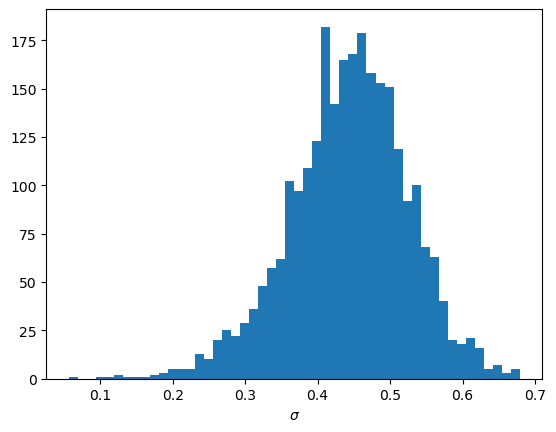

In [6]:
plt.figure()
plt.hist(confs, bins=50)
plt.xlabel(r'$\sigma$')
plt.show()

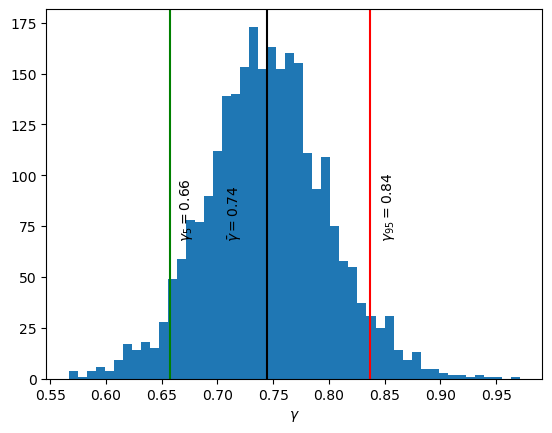

In [7]:
plt.figure()
plt.hist(gamma, bins=50)
plt.axvline(np.mean(gamma), color='k', linestyle='solid')
plt.text(np.mean(gamma)*0.95, 70, fr'$\bar\gamma={np.mean(gamma):.2f}$', rotation=90)
plt.axvline(np.percentile(gamma, 95), color='r', linestyle='solid')
plt.text(np.percentile(gamma, 95)*1.01, 70,
         fr'$\gamma_{{95}}={np.percentile(gamma, 95):.2f}$', rotation=90)
plt.axvline(np.percentile(gamma, 5), color='g', linestyle='solid')
plt.text(np.percentile(gamma, 5)*1.01, 70,
         fr'$\gamma_{{5}}={np.percentile(gamma, 5):.2f}$', rotation=90)
plt.xlabel(r'$\gamma$')
plt.show()

These are some of the poorer performing clusters ($\gamma$ < 0.4)

In [8]:
mask = (gamma < 0.4) & (gamma > 0)
sub_worst = sub_ids[mask][np.argsort(gamma[mask])]
print(len(sub_worst))
for sub in sub_worst[:10]:
    try:
        print(gamma[sub_ids == sub])
        aggregator.plot_subject(sub, 'T1')
    except Exception as e:
        #         print(e)
        continue

0


These are subjects that perform better than the average ($\gamma$ > 0.7)

2126
[0.70004884]


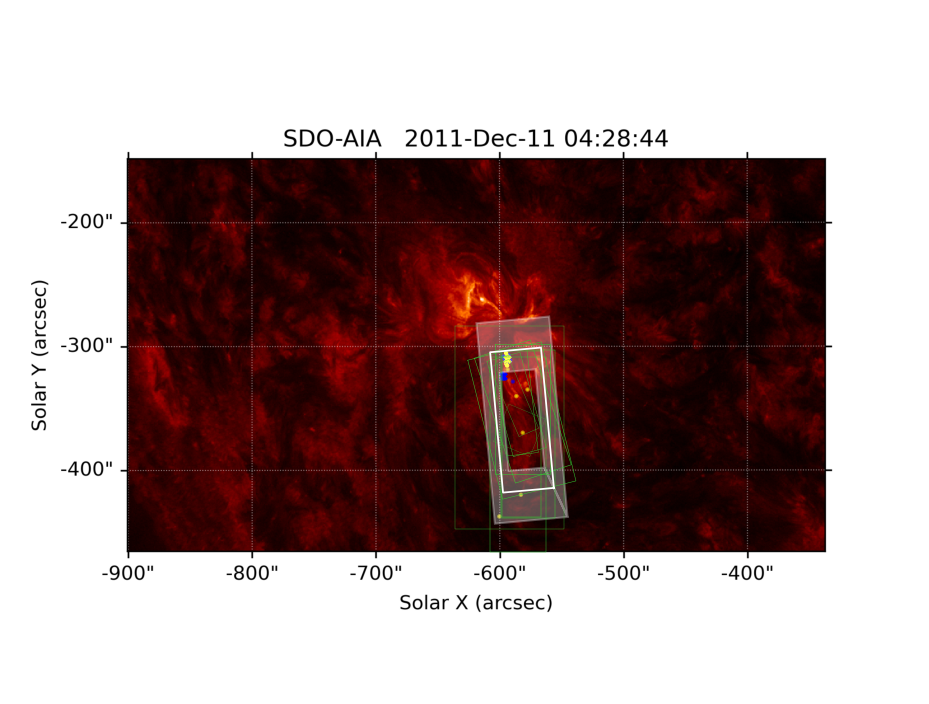

[0.70007526]


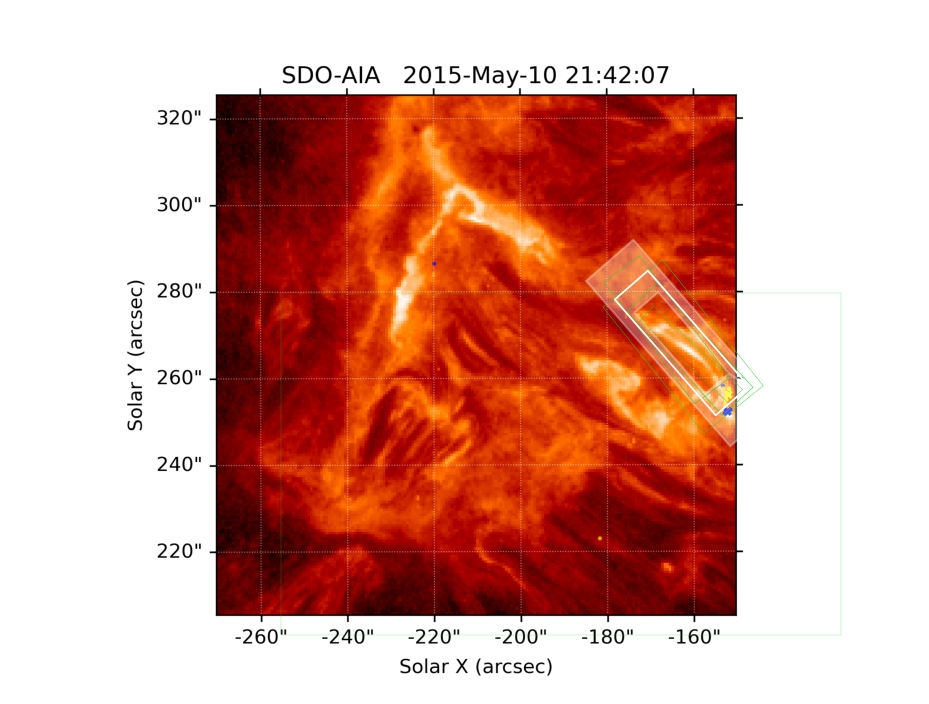

[0.70022698]


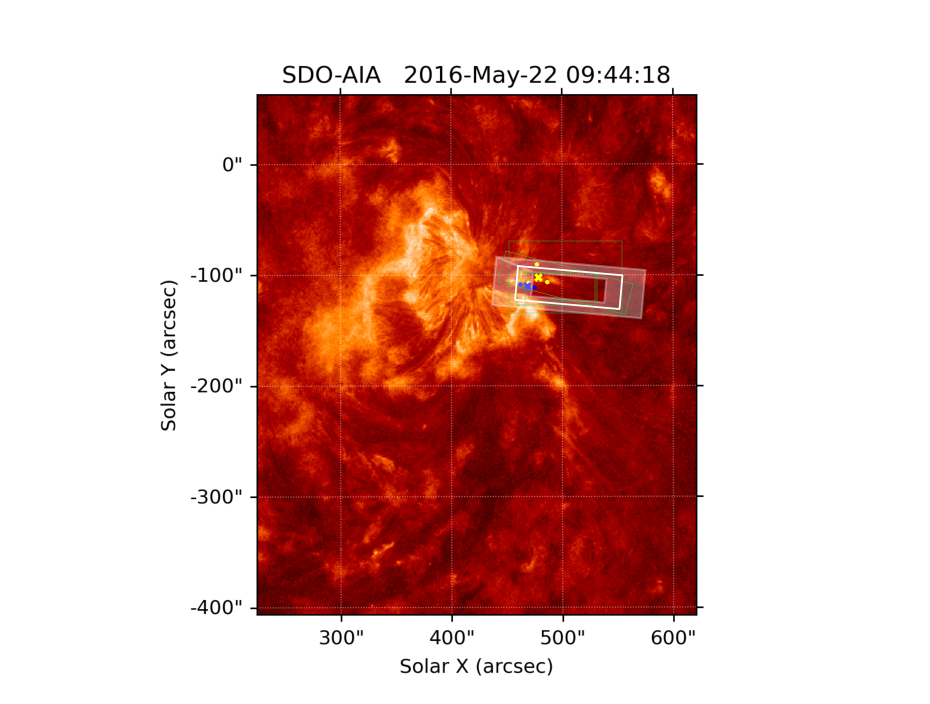

[0.70033753]


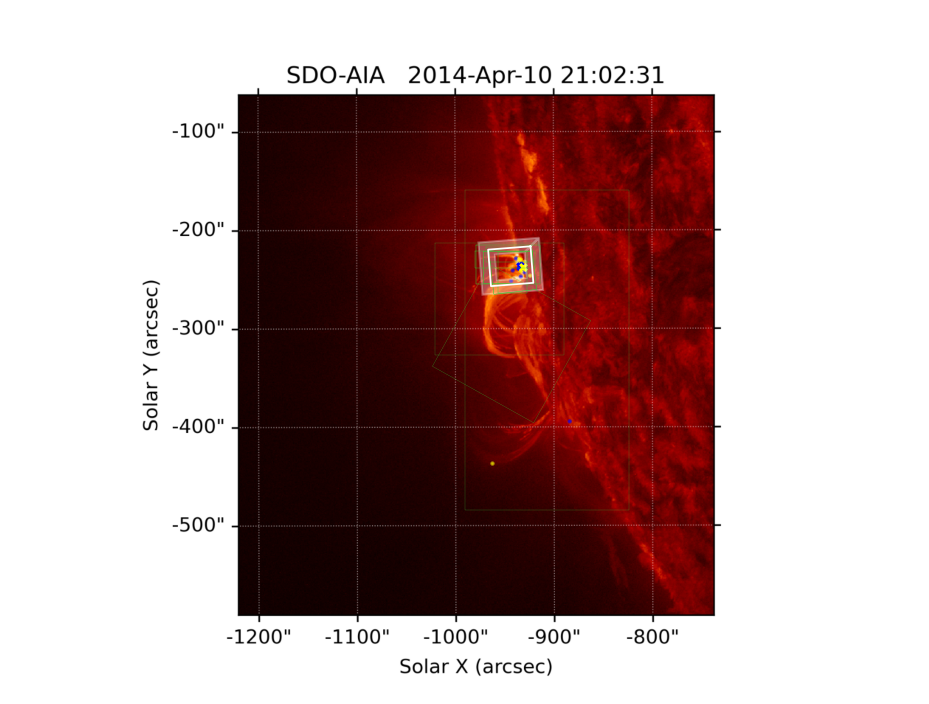

[0.70038497]


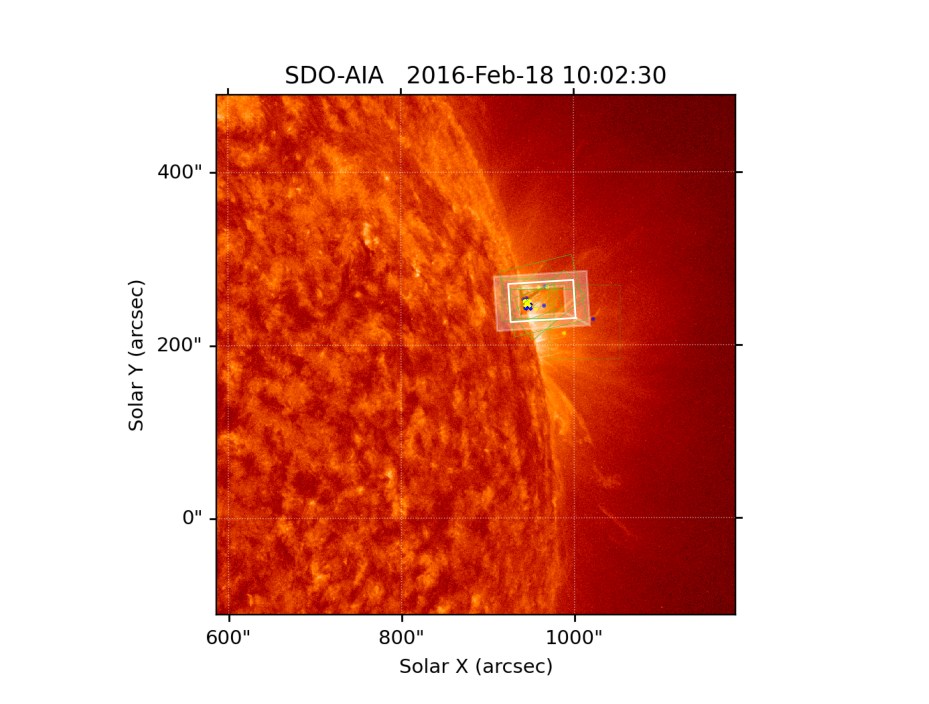

[0.70048897]


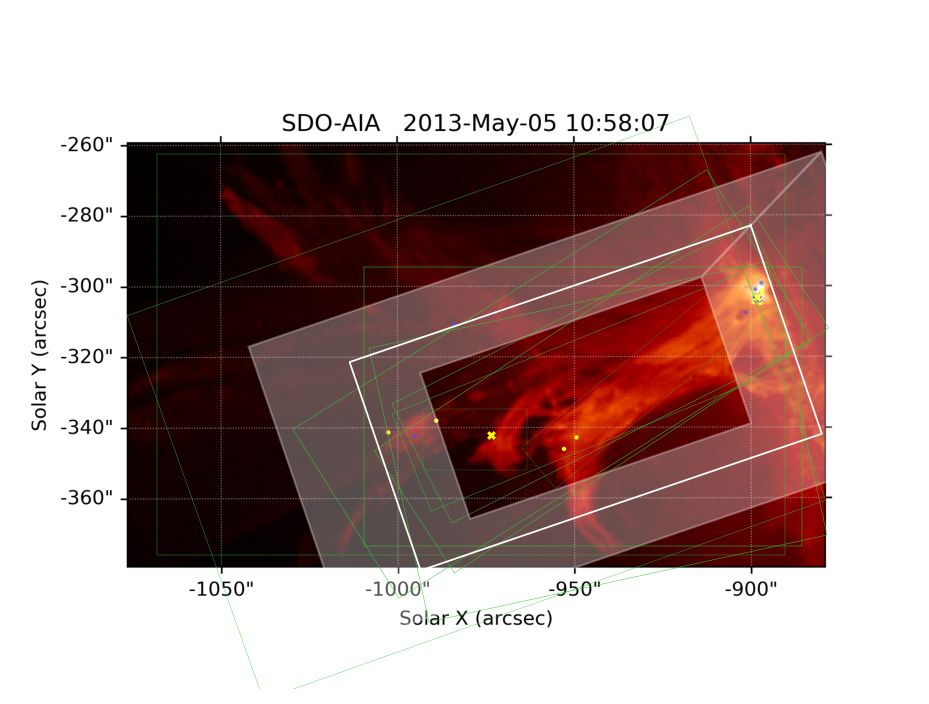

[0.70066696]


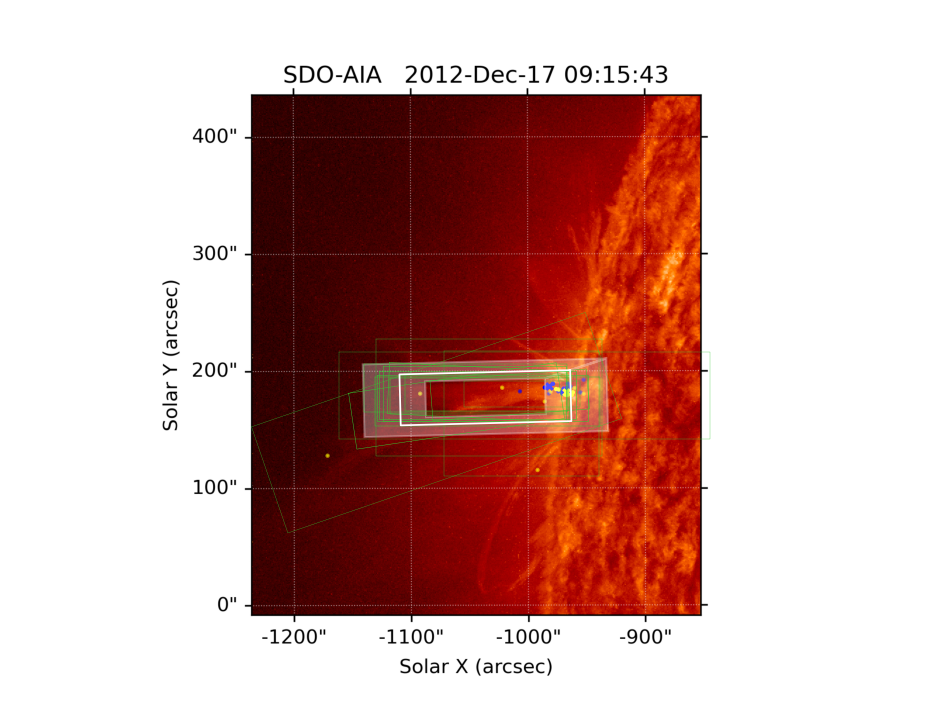

[0.7007718]


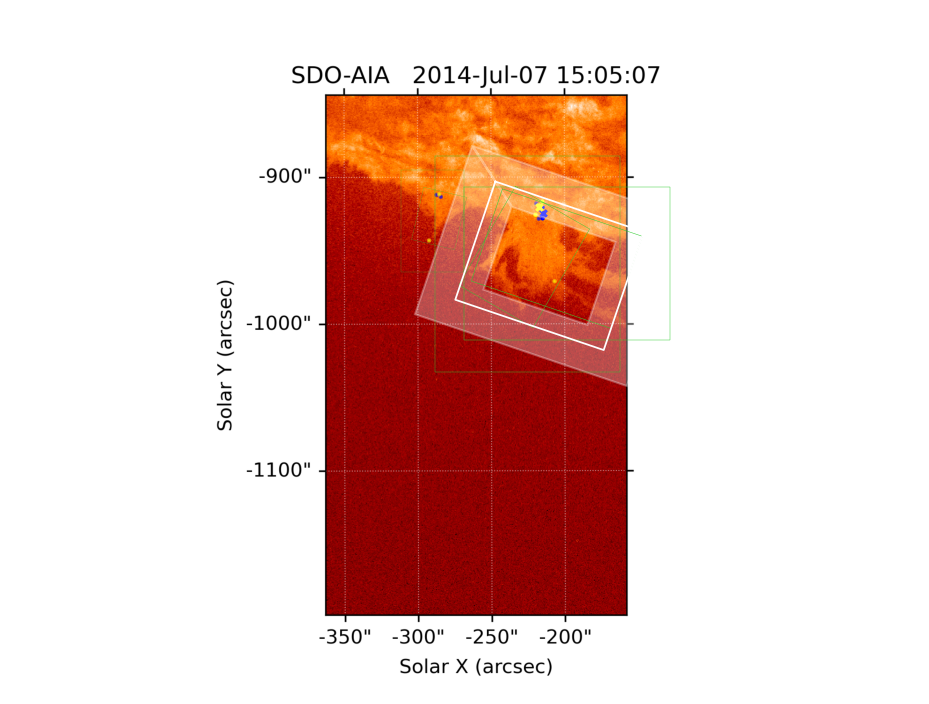

[0.7008394]


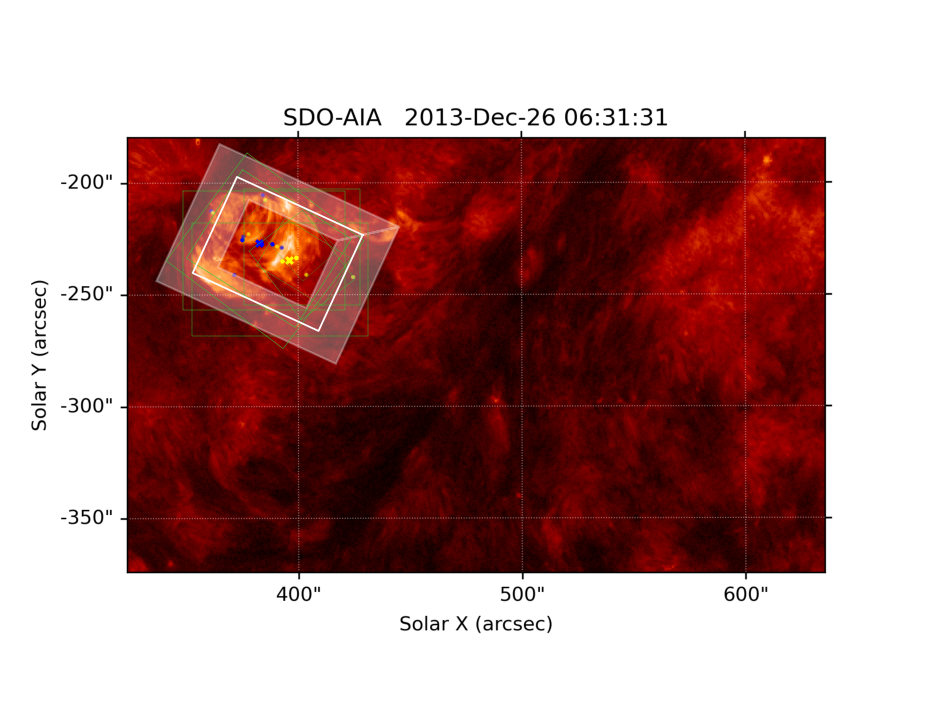

[0.70084339 0.73961218]


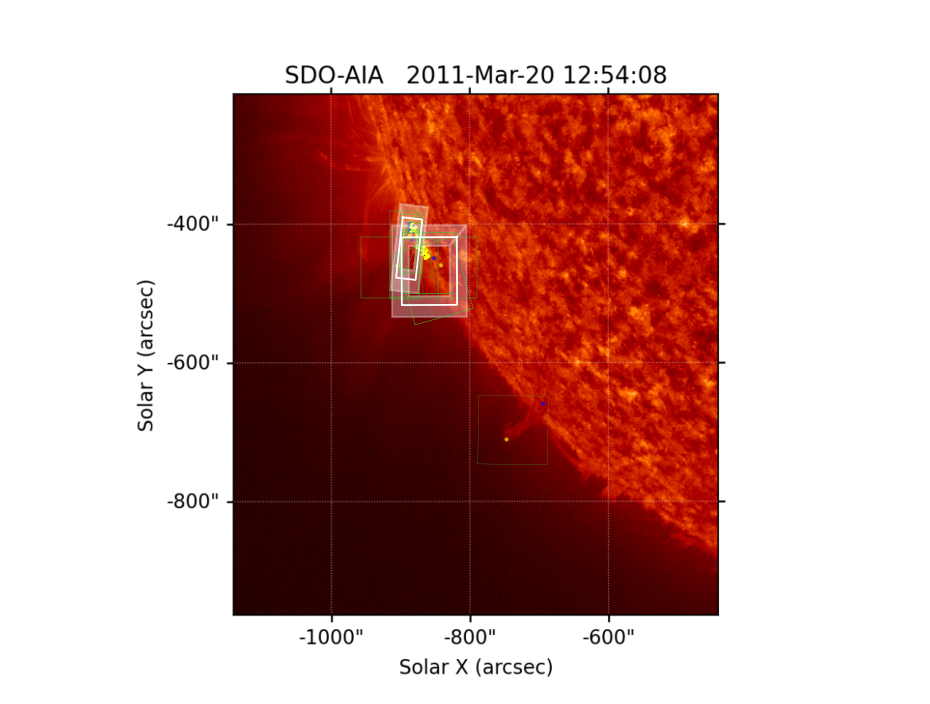

In [9]:
mask = (gamma > 0.7)
sub_best = sub_ids[mask][np.argsort(gamma[mask])]
print(len(sub_best))
for sub in sub_best[:10]:
    try:
        print(gamma[sub_ids == sub])
        aggregator.plot_subject(sub, 'T1')
    except Exception as e:
        #         print(e)
        continue